In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

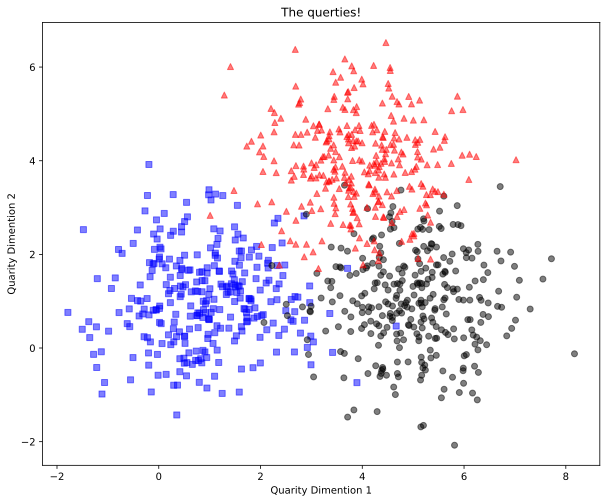

In [74]:
# Create and inspect the data

nPerCluster = 300  ## Change the value to 50 and then 1000 to see the effect on the learning performance
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate the data
a = [
    A[0] + np.random.randn(nPerCluster) * blur,
    A[1] + np.random.randn(nPerCluster) * blur,
]
b = [
    B[0] + np.random.randn(nPerCluster) * blur,
    B[1] + np.random.randn(nPerCluster) * blur,
]
c = [
    C[0] + np.random.randn(nPerCluster) * blur,
    C[1] + np.random.randn(nPerCluster) * blur,
]

# True labels
labels_np = np.hstack(
    (np.zeros((nPerCluster)), np.ones((nPerCluster)), 1 + np.ones((nPerCluster)))
)

# Concat into a matrix
data_np = np.hstack((a, b, c)).T

# Convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: Long format is for Cross Entropy Loss

# Show the data
fig = plt.figure(figsize=(10, 8))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)
plt.title("The querties!")
plt.xlabel("Quarity Dimention 1")
plt.ylabel("Quarity Dimention 2")
plt.show()

In [75]:
# Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1
)

# Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Finally translate it into dataloader objects
batchsize = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [76]:
# how many batches are there?

print(f"There are {len(train_loader)} batches, each with {batchsize} samples.")

There are 50 batches, each with 16 samples.


In [77]:
# Create model function
def createTheQuertyNet():
    # Class for the QuertyNet
    class QuertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2, 32)

            # Hidden Layers
            self.hidden1 = nn.Linear(32, 64)
            self.hidden2 = nn.Linear(64, 32)
            self.hidden3 = nn.Linear(32, 8)

            # Output Layer
            self.output = nn.Linear(8, 3)

            # # Reduce the number of units to 3 to see how model is doing now
            # # Input Layer
            # self.input = nn.Linear(2, 3)

            # # Hidden Layers
            # self.hidden1 = nn.Linear(3, 3)
            # self.hidden2 = nn.Linear(3, 3)
            # self.hidden3 = nn.Linear(3, 3)

            # # Output Layer
            # self.output = nn.Linear(3, 3)

        # Forwar Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = F.relu(self.hidden3(x))

            return self.output(x)

    # Model Instance
    net = QuertyNet()

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossFun, optimizer

In [78]:
# test the model with fake input

net, lossf, opt = createTheQuertyNet()
print(net)

# input is ten samples
input = torch.rand(10, 2)
net(input)

QuertyNet(
  (input): Linear(in_features=2, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.1042,  0.2455, -0.1443],
        [-0.1036,  0.2449, -0.1449],
        [-0.1054,  0.2448, -0.1429],
        [-0.1049,  0.2448, -0.1439],
        [-0.1123,  0.2495, -0.1395],
        [-0.1128,  0.2521, -0.1388],
        [-0.1046,  0.2503, -0.1456],
        [-0.1076,  0.2502, -0.1430],
        [-0.1107,  0.2506, -0.1408],
        [-0.1120,  0.2497, -0.1396]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [83]:
# Function to train the model
def trainTheModel():

    nEpochs = 1000

    # Create a new model
    net, lossFun, optimizer = createTheQuertyNet()

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):

        # Switch to training mode
        net.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for the batch
            batchLoss.append(loss.item())

            # Comput accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            batchAcc.append(100 * (torch.mean(matchesNumeric)).cpu())

            # End of batch loop
        # Average training accuracy across the batches
        trainAcc.append(np.mean(batchAcc))

        # Average losses across batches
        losses[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * (torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
        )

    # End of epoch

    # Function Output
    return trainAcc, testAcc, losses, net

In [84]:
# Run the model
trainAcc, testAcc, losses, net = trainTheModel()

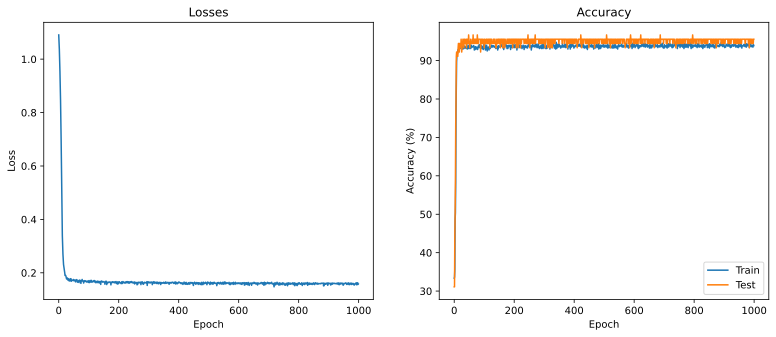

In [85]:
# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(losses.cpu().detach())
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

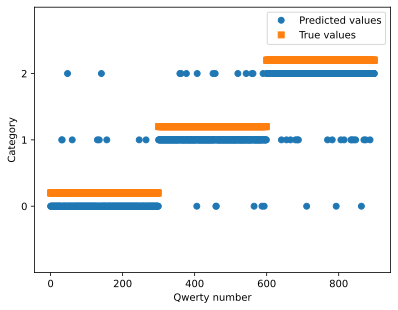

In [86]:
# Run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat, axis=1)

# Plot those against the real data
plt.plot(predictions.cpu(), "o", label="Predicted values")
plt.plot((labels + 0.2).cpu(), "s", label="True values")
plt.xlabel("Qwerty number")
plt.ylabel("Category")
plt.yticks([0, 1, 2])
plt.ylim([-1, 3])
plt.legend()
plt.show()

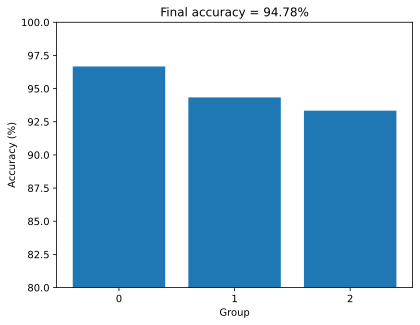

In [87]:
# recode each prediction by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100 * accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

plt.bar(range(3), accuracyByGroup)
plt.ylim([80, 100])
plt.xticks([0, 1, 2])
plt.xlabel("Group")
plt.ylabel("Accuracy (%)")
plt.title(f"Final accuracy = {totalAcc:.2f}%")
plt.show()

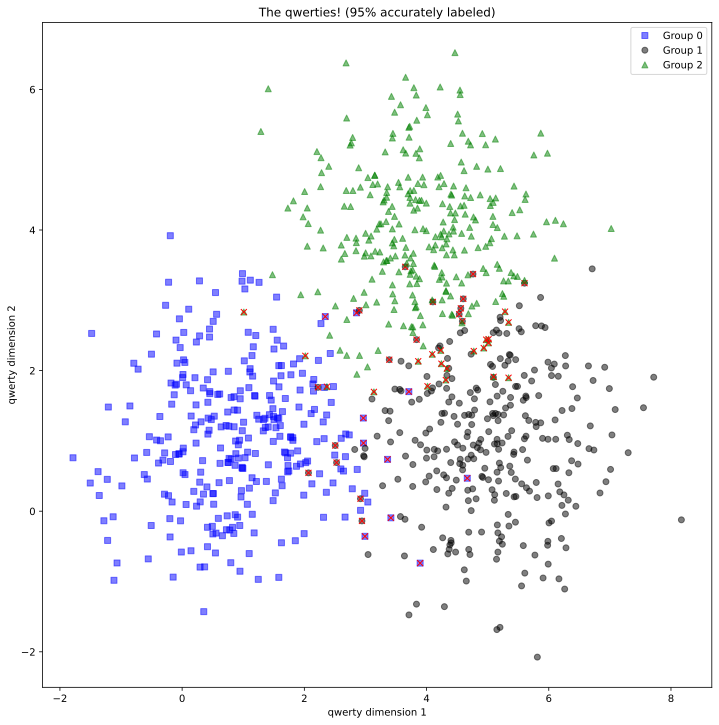

In [88]:
# Finally show the quarities in their native space, labeled by accuracy

# Data markers
colorShapes = ["bs", "ko", "g^"]

# Show the data
fig = plt.figure(figsize=(12, 12))

# Plot the correct and incorrect labeled data
for i in range(3):
    # Plot all the data points for the labels
    plt.plot(
        data[labels == i, 0].cpu(),
        data[labels == i, 1].cpu(),
        colorShapes[i],
        alpha=0.5,
        label=f"Group {i}",
    )

    # Crossout the incorrect labels
    idxErr = (accuracy == 0) & (labels == i)
    plt.plot(data[idxErr, 0].cpu(), data[idxErr, 1].cpu(), "rx")

plt.title(f"The qwerties! ({totalAcc:.0f}% accurately labeled)")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.legend()
plt.show()

In [89]:
# 1) There are three categories and 8 units in the hidden layer. Is that more units than we need? Try re-running the model
#    with 3 units insted of 8. Does the model still perform well? Does it perform equally well on all three categories?
# ====> Does pritty well but not in all category
# 2) One of the advantages of using simulated data is that you can have as much -- or as little -- data as possible. This
#    allows you to explore how much data the model needs for learning. Re-run this notebook using N=50/cluster (nb: you
#    might want to adjust the minibatch size). Is that enough to get good accuracy? Now try using N=1000/cluster. You can
#    run a parametric experiment to determine how model accuracy depends on the amount of data.
# ====> a.) With N=50 accuracy reduced by alot, b.) With N=1000 accuracy learning time increased by 2X but accuracy does not improve much
# 3) Where do you put torch.no_grad() to crash the model? That is, find the one line (or maybe there is more than one?)
#    where the following crashes the model:
#      with torch.no_grad():
#        <key line here>
#
#    What does your discovery tell you about where during training the gradients are computed and used?
# ====> If we put with torch.no_grad(): befor yHat calculation for training then it will crash the code due to no grad is available at the time of back prop
#